In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import kabuki
import seaborn as sns
%matplotlib inline
import hddm
print(hddm.__version__)

0.8.0


/opt/homebrew/Caskroom/miniforge/base/envs/pyHDDM/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
def read_models(filepath, n_chains=4):
    models=[]
    for i in range(n_chains):    
        models.append(hddm.load(f'{filepath}_{i}model'))
    return kabuki.utils.concat_models(models)

In [3]:
def hdi(ary, hdi_prob):
    """Compute hpi over the flattened array."""
    ary = ary.flatten()

    n = len(ary)


    ary = np.sort(ary)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = np.subtract(ary[interval_idx_inc:], ary[:n_intervals], dtype=np.float_)

    if len(interval_width) == 0:
        raise ValueError("Too few elements for interval calculation. ")

    min_idx = np.argmin(interval_width)
    hdi_min = ary[min_idx]
    hdi_max = ary[min_idx + interval_idx_inc]

    hdi_interval = np.array([hdi_min, hdi_max])

    return hdi_interval


In [4]:
def extract_params(model, contains=None):
    stats = model.gen_stats()
    if contains is not None:
        out = stats[stats.index.str.contains(contains,na=False)]
    else:
        out = stats
    return out 

def ttests(model_hia, model_loa, params=['a','t','v','z'], trials='101'):

    for param in params:
        hia = extract_params(model_hia, f'{param}_subj\({trials}\)')
        loa = extract_params(model_loa, f'{param}_subj\({trials}\)')
        h,p = scipy.stats.ttest_ind(hia['mean'], loa['mean'])
        print(f't-test {param} {trials} - p = {p:.4f} - t = {h:.4f}')

def compute_hdi(hia_101, loa_101, hia_102, loa_102, parameter_name, interval=0.95):
    hdi_hia_101 = hdi(hia_101.trace(), interval)
    hdi_loa_101 = hdi(loa_101.trace(), interval)

    hdi_diff_101 = hdi(hia_101.trace() - loa_101.trace(), interval)

    hdi_hia_102 = hdi(hia_102.trace(), interval)
    hdi_loa_102 = hdi(loa_102.trace(), interval)

    hdi_diff_102 = hdi(hia_102.trace() - loa_102.trace(), interval)

    print('mixed gamble')
    print(f'{parameter_name} {interval} HDI high anx = {hdi_hia_101}')
    print(f'{parameter_name} {interval} HDI low anx = {hdi_loa_101}')
    print(f'{parameter_name} {interval} HDI difference = {hdi_diff_101}')
    print()
    print('gain only')
    print(f'{parameter_name} {interval} HDI high anx = {hdi_hia_102}')
    print(f'{parameter_name} {interval} HDI low anx = {hdi_loa_102}')
    print(f'{parameter_name} {interval} HDI difference = {hdi_diff_102}')

def probabilities(hia_101, loa_101, hia_102, loa_102, parameter_name):
    print(f"{parameter_name} mixed-gamble P(High Anx > Low Anx) = {(hia_101.trace() > loa_101.trace()).mean():.3f}")
    print(f"{parameter_name} gain-only P(High Anx > Low Anx) = {(hia_102.trace() > loa_102.trace()).mean():.3f}")
    print()

def plot_posteriors(hia_101, loa_101, hia_102, loa_102, parameter_name):
    hddm.analyze.plot_posterior_nodes([hia_101, loa_101])
    plt.xlabel(f'{parameter_name}')
    plt.ylabel('Posterior probability')
    plt.title(f'Posterior of {parameter_name} group means - mixed gamble')
    plt.legend(['high anx', 'low anx'])
    plt.show()

    hddm.analyze.plot_posterior_nodes([hia_102, loa_102])
    plt.xlabel(f'{parameter_name}')
    plt.ylabel('Posterior probability')
    plt.title(f'Posterior of {parameter_name} group means - gain only')
    plt.legend(['high anx', 'low anx'])
    plt.show()

# Load data

In [5]:
model_loa = read_models('./tvz_loa_4c_4000s_1000b', n_chains=4)
model_hia = read_models('./tvz_hia_4c_4000s_1000b', n_chains=4)

# Check model

In [6]:
ttests(model_hia, model_loa, trials='101', params=['t','v','z'])
ttests(model_hia, model_loa, trials='102', params=['t','v','z'])

# a,t,v,z = model_hia.nodes_db.node[['a(101)','t(101)','v(101)','z(101)']]
# samples = {'a': a.trace(), 't': t.trace(), 'v': v.trace()}
# print(a.trace().shape, t.trace().shape, v.trace().shape)
# samp = pd.DataFrame(data=samples)


# def corrfunc(x, y, **kws):
#     r, _ = scipy.stats.pearsonr(x, y)
#     ax = plt.gca()
#     ax.annotate("r = {:.2f}".format(r), xy=(0.1, 0.9), xycoords=ax.transAxes)


# g = sns.PairGrid(samp, palette=["red"])
# g.map_upper(plt.scatter, s=10)
# g.map_diag(sns.distplot, kde=False)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
# g.map_lower(corrfunc)
# # g.savefig("matrix_plot.png")

t-test t 101 - p = 0.4256 - t = -0.7997
t-test v 101 - p = 0.2069 - t = -1.2693
t-test z 101 - p = 0.2832 - t = -1.0782
t-test t 102 - p = 0.2224 - t = -1.2270
t-test v 102 - p = 0.0607 - t = 1.8950
t-test z 102 - p = 0.1132 - t = -1.5962


# Analise a

In [7]:
# a_hia_101, a_hia_102 = model_hia.nodes_db.node[['a(101)', 'a(102)']]
# a_loa_101, a_loa_102 = model_loa.nodes_db.node[['a(101)', 'a(102)']]

# probabilities(a_hia_101, a_loa_101, a_hia_102, a_loa_102, 'boundary sep')

# compute_hdi(a_hia_101, a_loa_101, a_hia_102, a_loa_102, 'boundary sep')

# plot_posteriors(a_hia_101, a_loa_101, a_hia_102, a_loa_102, 'boundary sep')

# Analise t

non dec time mixed-gamble P(High Anx > Low Anx) = 0.220
non dec time gain-only P(High Anx > Low Anx) = 0.092

mixed gamble
non dec time 0.95 HDI high anx = [0.63576149 0.72783907]
non dec time 0.95 HDI low anx = [0.65850027 0.76425003]
non dec time 0.95 HDI difference = [-0.10011647  0.03995917]

gain only
non dec time 0.95 HDI high anx = [0.6388595  0.73130281]
non dec time 0.95 HDI low anx = [0.68010321 0.78817618]
non dec time 0.95 HDI difference = [-0.11836155  0.02579625]


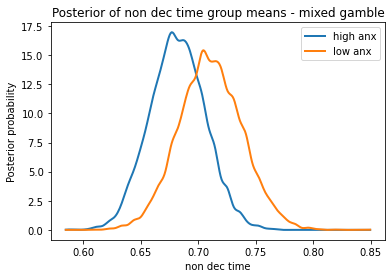

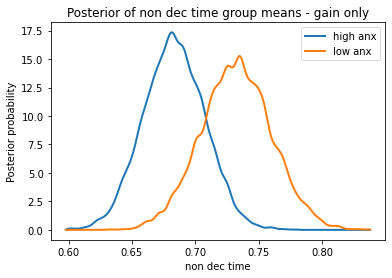

In [8]:
t_hia_101, t_hia_102 = model_hia.nodes_db.node[['t(101)', 't(102)']]
t_loa_101, t_loa_102 = model_loa.nodes_db.node[['t(101)', 't(102)']]

probabilities(t_hia_101, t_loa_101, t_hia_102, t_loa_102, 'non dec time')

compute_hdi(t_hia_101, t_loa_101, t_hia_102, t_loa_102, 'non dec time')

plot_posteriors(t_hia_101, t_loa_101, t_hia_102, t_loa_102, 'non dec time')

# Analise v

drift rate mixed-gamble P(High Anx > Low Anx) = 0.109
drift rate gain-only P(High Anx > Low Anx) = 0.931

mixed gamble
drift rate 0.95 HDI high anx = [-0.09919201  0.19906271]
drift rate 0.95 HDI low anx = [0.01734583 0.38320394]
drift rate 0.95 HDI difference = [-0.40633315  0.07196662]

gain only
drift rate 0.95 HDI high anx = [0.25055018 0.56623205]
drift rate 0.95 HDI low anx = [0.02783921 0.41539014]
drift rate 0.95 HDI difference = [-0.06080792  0.43309936]


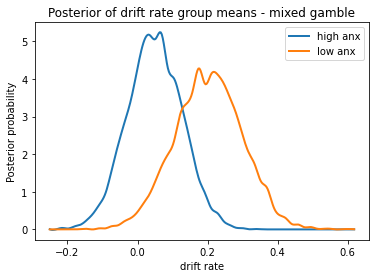

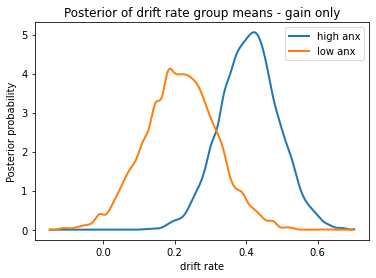

In [9]:
v_hia_101, v_hia_102 = model_hia.nodes_db.node[['v(101)', 'v(102)']]
v_loa_101, v_loa_102 = model_loa.nodes_db.node[['v(101)', 'v(102)']]

probabilities(v_hia_101, v_loa_101, v_hia_102, v_loa_102, 'drift rate')

compute_hdi(v_hia_101, v_loa_101, v_hia_102, v_loa_102, 'drift rate')

plot_posteriors(v_hia_101, v_loa_101, v_hia_102, v_loa_102, 'drift rate')

# Analise z

starting point mixed-gamble P(High Anx > Low Anx) = 0.207
starting point gain-only P(High Anx > Low Anx) = 0.178

mixed gamble
starting point 0.95 HDI high anx = [0.51145144 0.54772275]
starting point 0.95 HDI low anx = [0.52223313 0.55919102]
starting point 0.95 HDI difference = [-0.03648238  0.01315907]

gain only
starting point 0.95 HDI high anx = [0.48796109 0.53298153]
starting point 0.95 HDI low anx = [0.50226342 0.54578108]
starting point 0.95 HDI difference = [-0.04711176  0.01615499]


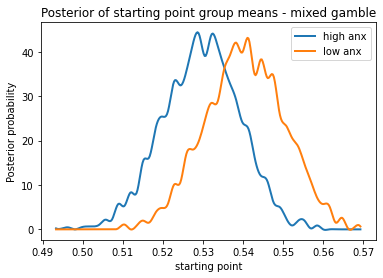

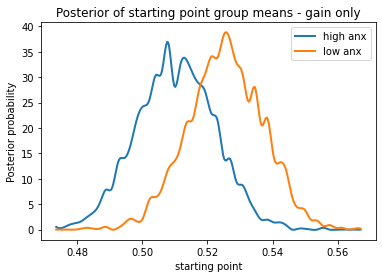

In [10]:
z_hia_101, z_hia_102 = model_hia.nodes_db.node[['z(101)', 'z(102)']]
z_loa_101, z_loa_102 = model_loa.nodes_db.node[['z(101)', 'z(102)']]

probabilities(z_hia_101, z_loa_101, z_hia_102, z_loa_102, 'starting point')

compute_hdi(z_hia_101, z_loa_101, z_hia_102, z_loa_102, 'starting point')

plot_posteriors(z_hia_101, z_loa_101, z_hia_102, z_loa_102, 'starting point')

# Extract params

In [11]:
def extract_params(model, contains=None):
    stats = model.gen_stats()
    if contains is not None:
        out = stats[stats.index.str.contains(contains,na=False)]
    else:
        out = stats
    return out 

def params(model, params=['a','t','v','z'], trials='101'):
    df = pd.DataFrame(columns=[f'{p}_{trials}' for p in params])
    out = []
    for param in params:
        ps = extract_params(model, f'{param}_subj\({trials}\)')
        # rename index to only subjID
        ps = ps.rename(lambda x: x[-16:])
        # store mean in the right column
        df[f'{param}_{trials}'] = ps['mean']
    return df

In [12]:
loa_101 = params(model_loa, params=['t','v','z'], trials='101')
loa_102 = params(model_loa, params=['t','v','z'], trials='102')

hia_101 = params(model_hia, params=['t','v','z'], trials='101')
hia_102 = params(model_hia, params=['t','v','z'], trials='102')

In [13]:
df_all_101 = pd.concat([loa_101, hia_101], axis = 0)
df_all_102 = pd.concat([loa_102, hia_102], axis = 0)

In [14]:
def pearsons_r(x, y):
    h,p = scipy.stats.pearsonr(x,y)
    print(f'h {h:.4f} - p {p:.4f}')

In [15]:
pearsons_r(df_all_101['t_101'], df_all_101['v_101'])
pearsons_r(df_all_101['t_101'], df_all_101['z_101'])
pearsons_r(df_all_101['v_101'], df_all_101['z_101'])

h -0.0178 - p 0.8501
h -0.0455 - p 0.6290
h 0.3176 - p 0.0005


In [16]:
pearsons_r(df_all_102['t_102'], df_all_102['v_102'])
pearsons_r(df_all_102['t_102'], df_all_102['z_102'])
pearsons_r(df_all_102['v_102'], df_all_102['z_102'])

h -0.2192 - p 0.0186
h 0.0432 - p 0.6465
h 0.0500 - p 0.5960
